In [1]:
import os
import h5py
import numba
import numpy as np
import pandas as pd
import scipy.integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
from hoki.utils.exceptions import HokiFormatError
from pylab import cm
from scipy.optimize import fminbound
import matplotlib.ticker as ticker
from matplotlib.patches import Patch

In [2]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth'] = 2

In [3]:
data = h5py.File(f"/Users/dillon/Desktop/data.h5", "r")
observations = data['observations']

obs_Ia = observations['Ia']
obs_CCSN = observations['CCSN']
obs_LGRB = observations['LGRB']
obs_PISN = observations['PISN']

In [4]:
event_rates = data['event_rates']
h = event_rates.attrs['h']

In [5]:
desktop_path = '/Users/dillon/Desktop/'

In [6]:
BPASS_files = ['100_100', '100_300', '135_100', '135_300', '135all_100', '170_100', '170_300']
models = ['empmodel', 'harikane22', 'MD', 'TNG', 'EAGLE', 'millimillennium']

In [7]:
obs_colors = {
    'Ia': 'grey',
    'CCSN': 'grey',
    'LGRB': 'grey',
    'PISN': 'grey',
}

In [8]:
model_data = {}

for model in models:
    model_data[model] = {}  
    for bpass_file in BPASS_files:
        folder_path = os.path.join(desktop_path, bpass_file)
        file_name = f"{model}_{bpass_file}.h5"
        file_path = os.path.join(folder_path, file_name)

        if os.path.exists(file_path):
            with h5py.File(file_path, 'r') as file:
                model_data[model][bpass_file] = {key: file[key][:] for key in file.keys()}

In [9]:
Ia_rates = {}
CCSN_rates = {}
LGRB_rates = {}
PISN_rates = {}

for model in models:
    Ia_rates[model] = {}  
    CCSN_rates[model] = {}  
    LGRB_rates[model] = {}  
    PISN_rates[model] = {}  

    for bpass_file in BPASS_files:
        folder_path = os.path.join(desktop_path, bpass_file)
        file_name = f"{model}_{bpass_file}.h5"
        file_path = os.path.join(folder_path, file_name)

        if os.path.exists(file_path):
            with h5py.File(file_path, 'r') as file:
                Ia_rates[model][bpass_file] = file['Ia_rates'][:]
                CCSN_rates[model][bpass_file] = file['CCSN_rates'][:]
                LGRB_rates[model][bpass_file] = file['LGRB_rates'][:]
                PISN_rates[model][bpass_file] = file['PISN_rates'][:]

In [10]:
def plot_fill_between(ax, events, model, bpass_file, model_data, color):
    x_axis_data = model_data[model][bpass_file]['redshift_edges'][:-1]
    all_min_rates = np.min([events[model][bf] for bf in BPASS_files], axis=0)
    all_max_rates = np.max([events[model][bf] for bf in BPASS_files], axis=0)
    max_difference = np.max(all_max_rates - all_min_rates)
    max_difference_index = np.argmax(all_max_rates - all_min_rates)
    max_difference_redshift = x_axis_data[max_difference_index]
    max_difference_values_upper = all_max_rates[max_difference_index]
    max_difference_values_lower = all_min_rates[max_difference_index]
    ax.fill_between(x_axis_data, all_min_rates, all_max_rates, color= color, alpha=0.1)

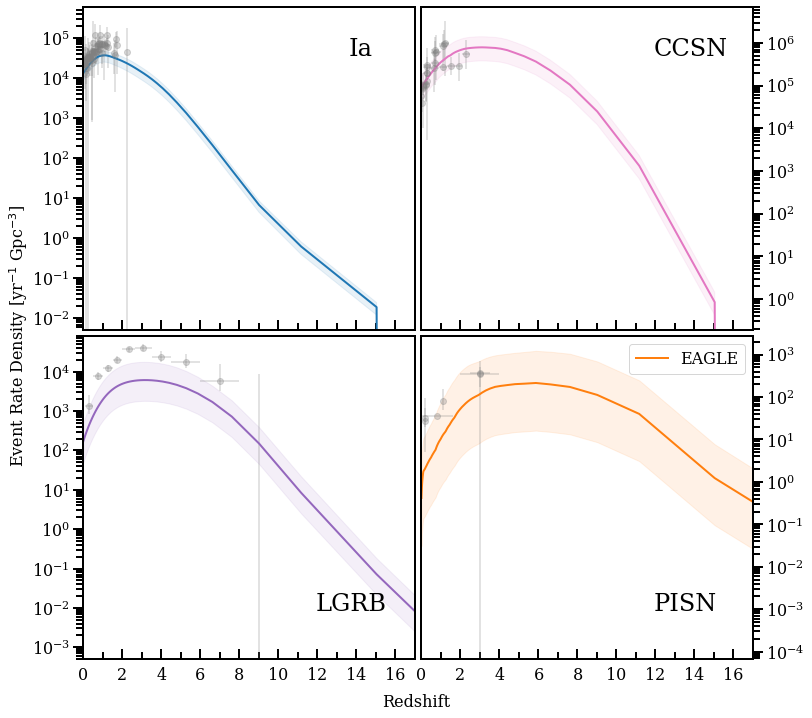

In [11]:
fig, axes = plt.subplots(2,2, figsize=(12,12))
fig.subplots_adjust(wspace=0.02, hspace = 0.02)

axs = axes.flatten()

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlim(0, 17)
    ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='out')
    ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='out')
    
    ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', pad=7)
    ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in')
    ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10, numticks=10))
    major_locator = ticker.MultipleLocator(base=2)
    minor_locator = ticker.MultipleLocator(base=1)
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.set_xticks(ax.get_xticks()[1:-1])
    ax.set_xticklabels([str(int(x)) for x in ax.get_xticks()])


for ax in axs[0:1]:
    ax.plot(model_data['TNG']['135_300']['redshift_edges'][:-1], Ia_rates['TNG']['135_300'], lw = 2, label = 'TNG')
    plot_fill_between(ax, Ia_rates, 'TNG', '135_300', model_data, '#1f77b4')
    
    ax.errorbar(
            np.array(obs_Ia['mean_z']),
            np.array(obs_Ia['rate']) * h**3,
            xerr= [obs_Ia['lower_z'], obs_Ia['upper_z']],
            yerr=[obs_Ia['lower_rate'] * h**3, obs_Ia['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color= 'grey'
    )
    ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
    ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='out')
    ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='out')
    minor_locator = ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10)
    ax.yaxis.set_minor_locator(minor_locator)

    ax.text(0.8, 0.85, "Ia", transform=ax.transAxes,fontsize=24)
    
    
for ax in axs[1:2]:
    ax.plot(model_data['millimillennium']['135_300']['redshift_edges'][:-1], CCSN_rates['millimillennium']['135_300'], color = '#e377c2', lw = 2, label = 'Millimillennium')
    plot_fill_between(ax, CCSN_rates, 'millimillennium', '135_300', model_data, color = '#e377c2')
    ax.errorbar(
            np.array(obs_CCSN['mean_z']),
            np.array(obs_CCSN['rate']) * h**3,
            xerr= [obs_CCSN['lower_z'], obs_CCSN['upper_z']],
            yerr=[obs_CCSN['lower_rate'] * h**3, obs_CCSN['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color= 'grey'
    )
    ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.yaxis.tick_right()
    ax.tick_params(axis='y', which='both')
    
    ax.text(0.7, 0.85, "CCSN", transform=ax.transAxes,fontsize=24)
    
for ax in axs[2:3]:
    ax.plot(model_data['harikane22']['135_100']['redshift_edges'][:-1], LGRB_rates['harikane22']['135_100'], color = '#9467bd', lw = 2, label = 'Harikane 22')
    plot_fill_between(ax, LGRB_rates, 'harikane22', '135_100', model_data, '#9467bd')
    ax.errorbar(
            np.array(obs_LGRB['mean_z']),
            np.array(obs_LGRB['rate']) * h**3,
            xerr= [obs_LGRB['lower_z'], obs_LGRB['upper_z']],
            yerr=[obs_LGRB['lower_rate'] * h**3, obs_LGRB['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color= 'grey'
    )
    
    ax.text(0.7, 0.15, "LGRB", transform=ax.transAxes,fontsize=24)
    
    ax.set_ylim(5e-4, 8e4)
    
for ax in axs[3:4]:
    ax.plot(model_data['EAGLE']['100_100']['redshift_edges'][:-1], PISN_rates['EAGLE']['100_100'], color = '#ff7f0e', lw =2, label = 'EAGLE')
    plot_fill_between(ax, PISN_rates, 'EAGLE', '100_100', model_data, '#ff7f0e')
    ax.errorbar(
            np.array(obs_PISN['mean_z']),
            np.array(obs_PISN['rate']) * h**3,
            xerr= [obs_PISN['lower_z'], obs_PISN['upper_z']],
            yerr=[obs_PISN['lower_rate'] * h**3, obs_PISN['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color= 'grey'
    )
    
    ax.yaxis.tick_right()
    ax.tick_params(axis='y', which='both')
    ax.text(0.7, 0.15, "PISN", transform=ax.transAxes,fontsize=24)
    
fig.text(0.05, 0.5, r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}$]", ha="center", va="center", rotation="vertical")
fig.text(0.51, 0.075, "Redshift", ha="center", va="center")

plt.legend()

In [12]:
def plot_fill_between_grey(ax, events, model, bpass_file, model_data):
    x_axis_data = model_data[model][bpass_file]['redshift_edges'][:-1]
    all_min_rates = np.min([events[model][bf] for bf in BPASS_files], axis=0)
    all_max_rates = np.max([events[model][bf] for bf in BPASS_files], axis=0)
    max_difference = np.max(all_max_rates - all_min_rates)
    max_difference_index = np.argmax(all_max_rates - all_min_rates)
    max_difference_redshift = x_axis_data[max_difference_index]
    max_difference_values_upper = all_max_rates[max_difference_index]
    max_difference_values_lower = all_min_rates[max_difference_index]
    ax.fill_between(x_axis_data, all_min_rates, all_max_rates, color= 'grey', alpha=0.05)

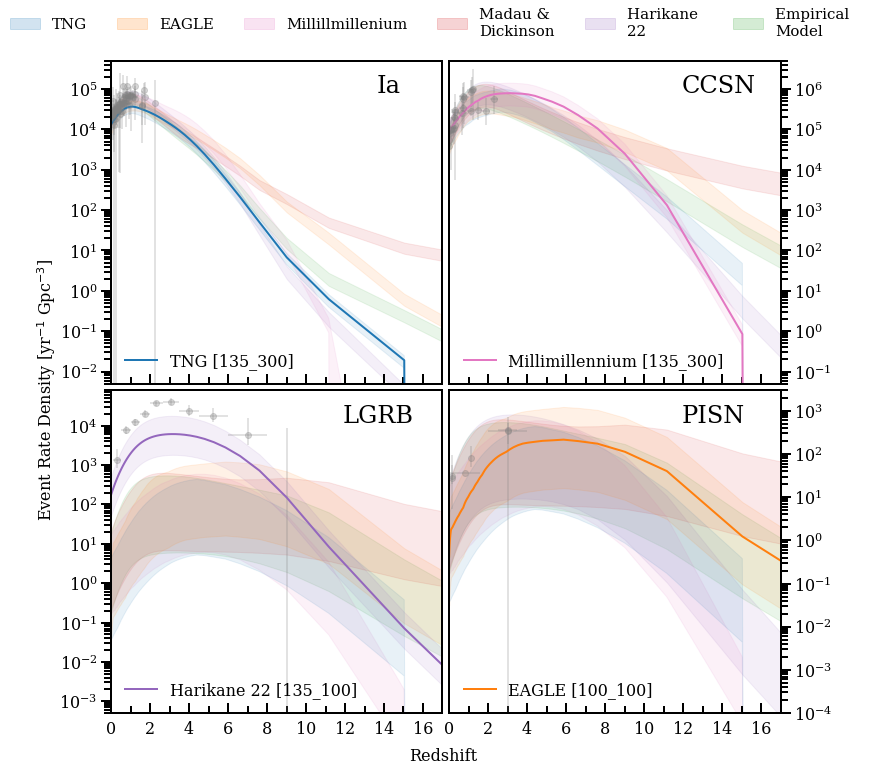

In [13]:
fig, axes = plt.subplots(2,2, figsize=(12,12))
fig.subplots_adjust(wspace=0.02, hspace = 0.02)

axs = axes.flatten()

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlim(0, 17)
    ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='out')
    ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='out')
    
    ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', pad=7)
    ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in')
    ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10, numticks=10))
    major_locator = ticker.MultipleLocator(base=2)
    minor_locator = ticker.MultipleLocator(base=1)
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.set_xticks(ax.get_xticks()[1:-1])
    ax.set_xticklabels([str(int(x)) for x in ax.get_xticks()])


for ax in axs[0:1]:
    ax.plot(model_data['TNG']['135_300']['redshift_edges'][:-1], Ia_rates['TNG']['135_300'], lw = 2, label = 'TNG [135_300]')

    plot_fill_between(ax, Ia_rates, 'empmodel', '135_300', model_data, '#2ca02c')
    plot_fill_between(ax, Ia_rates, 'harikane22', '135_300', model_data, '#9467bd')
    plot_fill_between(ax, Ia_rates, 'MD', '135_300', model_data, '#d62728')
    plot_fill_between(ax, Ia_rates, 'millimillennium', '135_300', model_data, '#e377c2')
    plot_fill_between(ax, Ia_rates, 'EAGLE', '135_300', model_data, '#ff7f0e')
    
    plot_fill_between(ax, Ia_rates, 'TNG', '135_300', model_data, '#1f77b4')
    
    
    
    ax.errorbar(
            np.array(obs_Ia['mean_z']),
            np.array(obs_Ia['rate']) * h**3,
            xerr= [obs_Ia['lower_z'], obs_Ia['upper_z']],
            yerr=[obs_Ia['lower_rate'] * h**3, obs_Ia['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color= 'grey'
    )
    ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
    ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='out')
    ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='out')
    minor_locator = ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10)
    ax.yaxis.set_minor_locator(minor_locator)

    ax.text(0.8, 0.9, "Ia", transform=ax.transAxes,fontsize=24)
    ax.legend(loc = 'lower left', frameon = False)
    ax.set_ylim(5e-3, 5e5)
    
for ax in axs[1:2]:
    ax.plot(model_data['millimillennium']['135_300']['redshift_edges'][:-1], CCSN_rates['millimillennium']['135_300'], color = '#e377c2', lw = 2, label = 'Millimillennium [135_300]')
    
    
    plot_fill_between(ax, CCSN_rates, 'empmodel', '135_300', model_data, '#2ca02c')
    plot_fill_between(ax, CCSN_rates, 'harikane22', '135_300', model_data, '#9467bd')
    plot_fill_between(ax, CCSN_rates, 'MD', '135_300', model_data, '#d62728')
    plot_fill_between(ax, CCSN_rates, 'TNG', '135_300', model_data, '#1f77b4')
    plot_fill_between(ax, CCSN_rates, 'EAGLE', '135_300', model_data, '#ff7f0e')
    
    plot_fill_between(ax, CCSN_rates, 'millimillennium', '135_300', model_data, color = '#e377c2')
    
    
    ax.errorbar(
            np.array(obs_CCSN['mean_z']),
            np.array(obs_CCSN['rate']) * h**3,
            xerr= [obs_CCSN['lower_z'], obs_CCSN['upper_z']],
            yerr=[obs_CCSN['lower_rate'] * h**3, obs_CCSN['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color= 'grey'
    )
    ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.yaxis.tick_right()
    ax.tick_params(axis='y', which='both')
    
    ax.text(0.7, 0.9, "CCSN", transform=ax.transAxes,fontsize=24)
    ax.legend(loc = 'lower left', frameon = False)
    
    ax.set_ylim(5e-2, 5e6)
    
for ax in axs[2:3]:
    ax.plot(model_data['harikane22']['135_100']['redshift_edges'][:-1], LGRB_rates['harikane22']['135_100'], color = '#9467bd', lw = 2, label = 'Harikane 22 [135_100]')
    
    plot_fill_between(ax, PISN_rates, 'empmodel', '135_300', model_data, '#2ca02c')
    plot_fill_between(ax, PISN_rates, 'MD', '135_300', model_data, '#d62728')
    plot_fill_between(ax, PISN_rates, 'millimillennium', '135_300', model_data, '#e377c2')
    plot_fill_between(ax, PISN_rates, 'TNG', '135_300', model_data, '#1f77b4')
    plot_fill_between(ax, PISN_rates, 'EAGLE', '100_100', model_data, '#ff7f0e')
    
    plot_fill_between(ax, LGRB_rates, 'harikane22', '135_100', model_data, '#9467bd')
    
    ax.errorbar(
            np.array(obs_LGRB['mean_z']),
            np.array(obs_LGRB['rate']) * h**3,
            xerr= [obs_LGRB['lower_z'], obs_LGRB['upper_z']],
            yerr=[obs_LGRB['lower_rate'] * h**3, obs_LGRB['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color= 'grey'
    )
    
    ax.text(0.7, 0.9, "LGRB", transform=ax.transAxes,fontsize=24)
    ax.legend(loc = 'lower left', frameon = False)
    
    ax.set_ylim(5e-4, 8e4)
    
for ax in axs[3:4]:
    ax.plot(model_data['EAGLE']['100_100']['redshift_edges'][:-1], PISN_rates['EAGLE']['100_100'], color = '#ff7f0e', lw =2, label = 'EAGLE [100_100]')
    
    plot_fill_between(ax, PISN_rates, 'empmodel', '135_300', model_data, '#2ca02c')
    plot_fill_between(ax, PISN_rates, 'harikane22', '135_300', model_data, '#9467bd')
    plot_fill_between(ax, PISN_rates, 'MD', '135_300', model_data, '#d62728')
    plot_fill_between(ax, PISN_rates, 'millimillennium', '135_300', model_data, '#e377c2')
    plot_fill_between(ax, PISN_rates, 'TNG', '135_300', model_data, '#1f77b4')
    
    plot_fill_between(ax, PISN_rates, 'EAGLE', '100_100', model_data, '#ff7f0e')
    
    
    ax.errorbar(
            np.array(obs_PISN['mean_z']),
            np.array(obs_PISN['rate']) * h**3,
            xerr= [obs_PISN['lower_z'], obs_PISN['upper_z']],
            yerr=[obs_PISN['lower_rate'] * h**3, obs_PISN['upper_rate'] * h**3],
            fmt="o",
            ms=6,
            alpha=0.3,
            color= 'grey'
    )
    
    ax.yaxis.tick_right()
    ax.tick_params(axis='y', which='both')
    ax.text(0.7, 0.9, "PISN", transform=ax.transAxes,fontsize=24)
    ax.legend(loc = 'lower left', frameon = False)
    ax.set_ylim(1e-4, 3e3)
    
fig.text(0.05, 0.5, r"Event Rate Density [yr$^{-1}$ Gpc$^{-3}$]", ha="center", va="center", rotation="vertical")
fig.text(0.51, 0.075, "Redshift", ha="center", va="center")


legend_labels = ['TNG', 'EAGLE', 'Millillmillenium', 'Madau & \nDickinson', 'Harikane \n22', 'Empirical \nModel']
legend_colors = ['#1f77b4', '#ff7f0e', '#e377c2', '#d62728', '#9467bd', '#2ca02c']

fig.legend(handles=[Patch(color=color, label=label, alpha = 0.2) for color, label in zip(legend_colors, legend_labels)],
           loc='upper center', bbox_to_anchor=(0.5, 0.9), fontsize=15, frameon=False, ncol = 6)


###Creates space above plot :) 
fig.legend(handles=[Patch(color=color, label=label, alpha = 0.2) for color, label in zip(legend_colors, legend_labels)],
           loc='upper center', bbox_to_anchor=(0.5, 0.95), fontsize=13, frameon=False, ncol = 6)


#plt.tight_layout()

plt.savefig('/Users/dillon/Desktop/EM ALl Models Range', bbox_inches='tight') 


## Peaks

In [14]:
def calculate_peak_redshift(model_data, event_rates, model_name, event_name):
    peak_100_100 = model_data[model_name]['100_100']['redshift_edges'][:-1][np.argmax(event_rates[model_name]['100_100'])]
    peak_100_300 = model_data[model_name]['100_300']['redshift_edges'][:-1][np.argmax(event_rates[model_name]['100_300'])]
    peak_135_100 = model_data[model_name]['135_100']['redshift_edges'][:-1][np.argmax(event_rates[model_name]['135_100'])]
    peak_135all_100 = model_data[model_name]['135all_100']['redshift_edges'][:-1][np.argmax(event_rates[model_name]['135all_100'])]
    peak_135_300 = model_data[model_name]['135_300']['redshift_edges'][:-1][np.argmax(event_rates[model_name]['135_300'])]
    peak_170_100 = model_data[model_name]['170_100']['redshift_edges'][:-1][np.argmax(event_rates[model_name]['170_100'])]
    peak_170_300 = model_data[model_name]['170_300']['redshift_edges'][:-1][np.argmax(event_rates[model_name]['170_300'])]

    average_peak_redshift = np.mean([
        peak_100_100, peak_100_300, peak_135_100,
        peak_135all_100, peak_135_300, peak_170_100, peak_170_300
    ])

    print(f"Average Peak Redshift ({event_name} - {model_name}): {average_peak_redshift}")


TNG

In [15]:
calculate_peak_redshift(model_data, Ia_rates, 'TNG', 'Ia')

calculate_peak_redshift(model_data, CCSN_rates, 'TNG', 'CCSN')

calculate_peak_redshift(model_data, LGRB_rates, 'TNG', 'LGRB')

calculate_peak_redshift(model_data, PISN_rates, 'TNG', 'PISN')

Average Peak Redshift (Ia - TNG): 1.0887624983599409
Average Peak Redshift (CCSN - TNG): 2.631982492326683
Average Peak Redshift (LGRB - TNG): 4.065633896017329
Average Peak Redshift (PISN - TNG): 4.401407604967409


EAGLE

In [16]:
calculate_peak_redshift(model_data, Ia_rates, 'EAGLE', 'Ia')

calculate_peak_redshift(model_data, CCSN_rates, 'EAGLE', 'CCSN')

calculate_peak_redshift(model_data, LGRB_rates, 'EAGLE', 'LGRB')

calculate_peak_redshift(model_data, PISN_rates, 'EAGLE', 'PISN')

Average Peak Redshift (Ia - EAGLE): 1.1667411350334527
Average Peak Redshift (CCSN - EAGLE): 2.010194713319017
Average Peak Redshift (LGRB - EAGLE): 3.463099212595453
Average Peak Redshift (PISN - EAGLE): 5.866901425273777


Millimillennium

In [17]:
calculate_peak_redshift(model_data, Ia_rates, 'millimillennium', 'Ia')

calculate_peak_redshift(model_data, CCSN_rates, 'millimillennium', 'CCSN')

calculate_peak_redshift(model_data, LGRB_rates, 'millimillennium', 'LGRB')

calculate_peak_redshift(model_data, PISN_rates, 'millimillennium', 'PISN')

Average Peak Redshift (Ia - millimillennium): 1.2082231520524689
Average Peak Redshift (CCSN - millimillennium): 3.109301738676334
Average Peak Redshift (LGRB - millimillennium): 4.401407604967409
Average Peak Redshift (PISN - millimillennium): 4.628248453350333


MD

In [18]:
calculate_peak_redshift(model_data, Ia_rates, 'MD', 'Ia')

calculate_peak_redshift(model_data, CCSN_rates, 'MD', 'CCSN')

calculate_peak_redshift(model_data, LGRB_rates, 'MD', 'LGRB')

calculate_peak_redshift(model_data, PISN_rates, 'MD', 'PISN')

Average Peak Redshift (Ia - MD): 0.9924139098263208
Average Peak Redshift (CCSN - MD): 1.847216376561299
Average Peak Redshift (LGRB - MD): 2.631982492326683
Average Peak Redshift (PISN - MD): 2.804437424029288


Empirical Model

In [19]:
calculate_peak_redshift(model_data, Ia_rates, 'empmodel', 'Ia')

calculate_peak_redshift(model_data, CCSN_rates, 'empmodel', 'CCSN')

calculate_peak_redshift(model_data, LGRB_rates, 'empmodel', 'LGRB')

calculate_peak_redshift(model_data, PISN_rates, 'empmodel', 'PISN')

Average Peak Redshift (Ia - empmodel): 0.8792017013354385
Average Peak Redshift (CCSN - empmodel): 1.5761110881566869
Average Peak Redshift (LGRB - empmodel): 2.7755372819097732
Average Peak Redshift (PISN - empmodel): 3.17293617296268


Harikane 22

In [21]:
calculate_peak_redshift(model_data, Ia_rates, 'harikane22', 'Ia')

calculate_peak_redshift(model_data, CCSN_rates, 'harikane22', 'CCSN')

calculate_peak_redshift(model_data, LGRB_rates, 'harikane22', 'LGRB')

calculate_peak_redshift(model_data, PISN_rates, 'harikane22', 'PISN')

Average Peak Redshift (Ia - harikane22): 1.0167195307733845
Average Peak Redshift (CCSN - harikane22): 1.91421997801259
Average Peak Redshift (LGRB - harikane22): 3.109301738676334
Average Peak Redshift (PISN - harikane22): 3.574984009580444
